In [3]:
!pip install pykalman

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.4/249.4 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.5/149.5 kB 14.1 MB/s eta 0:00:00


In [4]:
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from statsmodels.tsa.stattools import coint, adfuller
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from tensorflow.keras.callbacks import EarlyStopping
from pykalman import KalmanFilter
import seaborn
import seaborn as sns; sns.set(style="whitegrid")
# Define FX symbols
symbols = ['KO', 'PEP', 'MNST', 'FIZZ']
# Fetch historical stock data
stock_data = yf.download(symbols, start="2012-01-02", end="2025-09-17", progress=False)
# Extract the 'Close' prices from the fetched data
closing_prices = stock_data["Close"]


/tmp/ipython-input-330620234.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(symbols, start="2012-01-02", end="2025-09-17", progress=False)


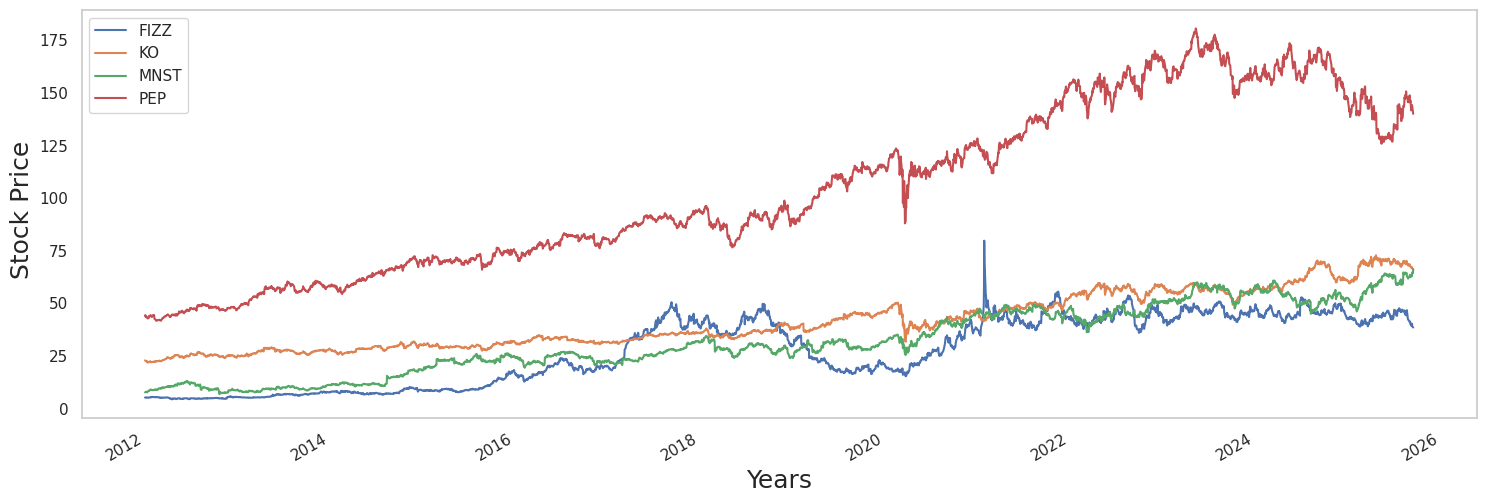

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [74]:
# Plot the closing prices
closing_prices.plot(figsize=(18, 6))
plt.title("")
plt.xlabel("Years", fontsize=18)
plt.ylabel(" Stock Price", fontsize=18)
plt.legend()
plt.grid(False)
plt.savefig("closing.eps", format='eps', dpi=300)
plt.show()
from google.colab import files

files.download("closing.eps")


In [5]:
# Calculate the Pearson correlation coefficient
Hlompho = closing_prices.ffill()

correlation_coefficient = Hlompho.corr()
print("Pearson Correlation Coefficient:")
print(correlation_coefficient)

Pearson Correlation Coefficient:
Ticker      FIZZ        KO      MNST       PEP
Ticker                                        
FIZZ    1.000000  0.807515  0.873207  0.850877
KO      0.807515  1.000000  0.942674  0.940881
MNST    0.873207  0.942674  1.000000  0.949372
PEP     0.850877  0.940881  0.949372  1.000000


In [6]:
##### Extracting Highly correlated Stock Prices  ###

correlation_matrix = Hlompho.corr()
correlation_threshold = 0.80

# Extract highly correlated stock pairs
highly_correlated_pairs = []
for i in range(len(symbols)):
    for j in range(i + 1, len(symbols)):
        if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
            highly_correlated_pairs.append((symbols[i], symbols[j]))

print("Highly correlated stock pairs:")
for pair in highly_correlated_pairs:
    print(pair)

Highly correlated stock pairs:
('KO', 'PEP')
('KO', 'MNST')
('KO', 'FIZZ')
('PEP', 'MNST')
('PEP', 'FIZZ')
('MNST', 'FIZZ')


In [7]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint

# List of highly correlated FX pairs
high_corr_pairs = [
    ('KO', 'PEP'),
    ('KO', 'MNST'),
    ('KO', 'FIZZ'),
    ('PEP', 'MNST'),
    ('PEP', 'FIZZ'),
    ('MNST', 'FIZZ')]

# Dictionary to store results
cointegration_results = {}

# Test each pair for cointegration
for pair in high_corr_pairs:
    y = Hlompho[pair[0]]
    x = Hlompho[pair[1]]

    score, pvalue, _ = coint(y, x)
    cointegration_results[pair] = pvalue

    if pvalue < 0.05:
        status = "Cointegrated → suitable for pairs trading"
    else:
        status = "Not cointegrated → NOT suitable for pairs trading"

    print(f"{pair[0]} & {pair[1]}: p-value = {pvalue:.4f} → {status}")

KO & PEP: p-value = 0.8522 → Not cointegrated → NOT suitable for pairs trading
KO & MNST: p-value = 0.0404 → Cointegrated → suitable for pairs trading
KO & FIZZ: p-value = 0.7455 → Not cointegrated → NOT suitable for pairs trading
PEP & MNST: p-value = 0.6147 → Not cointegrated → NOT suitable for pairs trading
PEP & FIZZ: p-value = 0.2526 → Not cointegrated → NOT suitable for pairs trading
MNST & FIZZ: p-value = 0.5627 → Not cointegrated → NOT suitable for pairs trading


In [11]:
import pandas as pd
from statsmodels.tsa.vector_ar.vecm import coint_johansen

# Use the four beverage stocks
data = Hlompho[["KO", "PEP", "MNST", "FIZZ"]].dropna()

# Run Johansen cointegration test
johansen_test = coint_johansen(data, det_order=0, k_ar_diff=1)

# Display Trace and Max-Eigen statistics
trace_stats = pd.DataFrame({
    "Trace Statistic": johansen_test.lr1,
    "90% CV": johansen_test.cvt[:, 0],
    "95% CV": johansen_test.cvt[:, 1],
    "99% CV": johansen_test.cvt[:, 2]
})

maxeig_stats = pd.DataFrame({
    "Max-Eigen Statistic": johansen_test.lr2,
    "90% CV": johansen_test.cvm[:, 0],
    "95% CV": johansen_test.cvm[:, 1],
    "99% CV": johansen_test.cvm[:, 2]
})

print("Trace Test Results:\n", trace_stats, "\n")
print("Max-Eigen Test Results:\n", maxeig_stats, "\n")

# Extract cointegration vectors (the betas)
cointegration_vectors = pd.DataFrame(johansen_test.evec,
                                     index=["KO", "PEP", "MNST", "FIZZ"])
print("Cointegration Vectors:\n", cointegration_vectors)


Trace Test Results:
    Trace Statistic   90% CV   95% CV   99% CV
0        29.353207  44.4929  47.8545  54.6815
1        12.961429  27.0669  29.7961  35.4628
2         4.329282  13.4294  15.4943  19.9349
3         1.141790   2.7055   3.8415   6.6349 

Max-Eigen Test Results:
    Max-Eigen Statistic   90% CV   95% CV   99% CV
0            16.391777  25.1236  27.5858  32.7172
1             8.632147  18.8928  21.1314  25.8650
2             3.187493  12.2971  14.2639  18.5200
3             1.141790   2.7055   3.8415   6.6349 

Cointegration Vectors:
              0         1         2         3
KO    0.204732 -0.105497 -0.108372  0.035020
PEP  -0.014389 -0.018681  0.076352 -0.045823
MNST -0.191782  0.036656 -0.062851  0.143045
FIZZ  0.083280  0.099815  0.001277 -0.011379


Text(0, 0.5, 'spread')

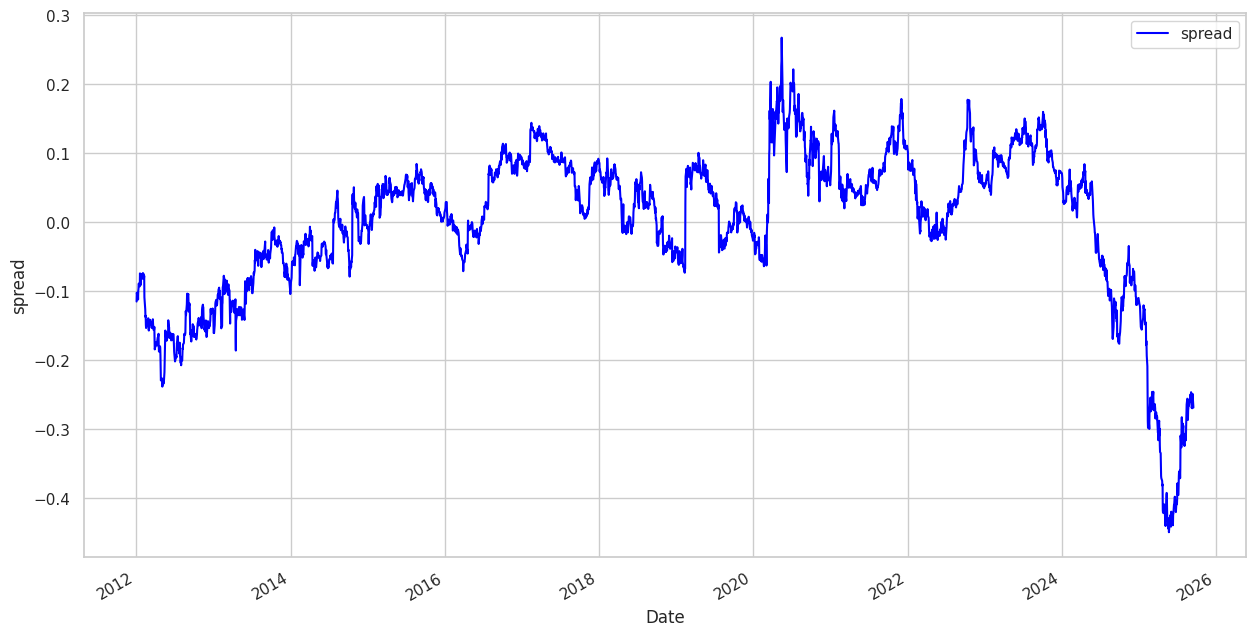

In [9]:
# Run linear regression over two log price series
x = list(np.log(Hlompho[symbols[0]]))
x_const = sm.add_constant(x)
y = list(np.log(Hlompho[symbols[1]]))
linear_reg = sm.OLS(y,x_const)
results = linear_reg.fit()

beta = results.params[1]
alpha = results.params[0]
y_pred = np.log(Hlompho[symbols[0]])*beta + alpha

# construct the spread series according to OLS result
Makatjane= pd.DataFrame(np.log(Hlompho[symbols[1]]) - np.log(Hlompho[symbols[0]])*beta-alpha,index=Hlompho[symbols[0]].index)
Makatjane.columns = ['spread']
Makatjane.plot(figsize =(15,8), color='blue')
plt.ylabel('spread')

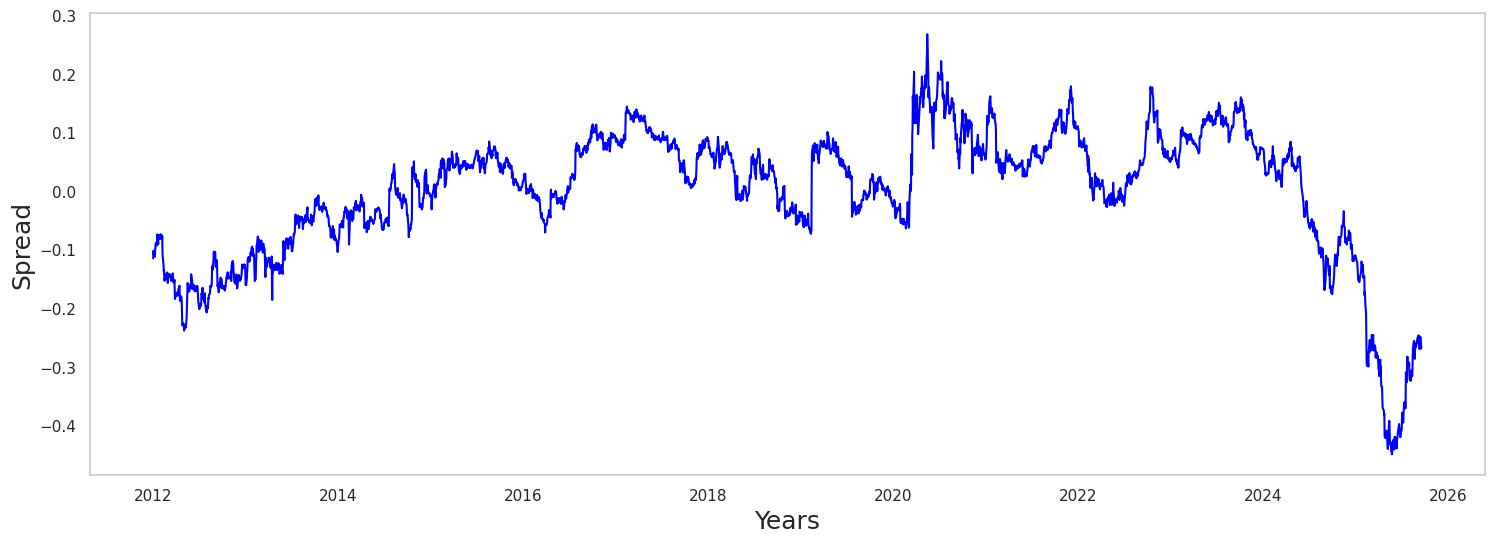

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [13]:
# Plot the spread
plt.figure(figsize=(18,6))
plt.plot(Makatjane.index, Makatjane['spread'], color='blue')
plt.ylabel('Spread', fontsize=18)
plt.grid(False)
# Save as high-resolution EPS
plt.savefig("spread_plot.eps", format='eps', dpi=600, bbox_inches='tight')
plt.xlabel("Years", fontsize=18)
plt.show()
from google.colab import files
files.download("spread_plot.eps")


In [14]:
test_size = 0.2
split_index = int(len(Makatjane) * (1 - test_size))

train_spread = Makatjane['spread'][:split_index]
test_spread = Makatjane['spread'][split_index:]


1️⃣ Prepare LSTM input (sliding windows)

In [26]:
# ---------------------------
# 0. Imports and seed
# ---------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# Reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# ---------------------------
# 1. Prepare sequences (window_size = 30)
# ---------------------------
window_size = 30
# Use the 'spread' column from the Makatjane DataFrame
train_spread = Makatjane['spread'][:int(0.8*len(Makatjane))]
test_spread = Makatjane['spread'][int(0.8*len(Makatjane)):]

def create_sequences(series, window):
    X, y = [], []
    for i in range(window, len(series)):
        X.append(series[i-window:i].values)
        y.append(series[i])
    X = np.array(X)
    y = np.array(y).reshape(-1,1)
    return X, y

X_train, y_train = create_sequences(train_spread, window_size)
X_test, y_test = create_sequences(test_spread, window_size)

# ---------------------------
# 2. Scale sequences
# ---------------------------
lstm_scaler_X = MinMaxScaler()
lstm_scaler_y = MinMaxScaler()

X_train_scaled = lstm_scaler_X.fit_transform(X_train.reshape(X_train.shape[0], -1))
X_train_scaled = X_train_scaled.reshape(X_train.shape[0], X_train.shape[1], 1)
y_train_scaled = lstm_scaler_y.fit_transform(y_train)

X_test_scaled = lstm_scaler_X.transform(X_test.reshape(X_test.shape[0], -1))
X_test_scaled = X_test_scaled.reshape(X_test.shape[0], X_test.shape[1], 1)
y_test_scaled = lstm_scaler_y.transform(y_test)

# ---------------------------
# 3. Build LSTM model
# ---------------------------
model = Sequential()
model.add(LSTM(64, activation='tanh', return_sequences=True, input_shape=(X_train_scaled.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = model.fit(
    X_train_scaled, y_train_scaled,
    epochs=200,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# ---------------------------
# 4. Predict spread
# ---------------------------
predicted_scaled_test = model.predict(X_test_scaled)
predicted_test_spread = lstm_scaler_y.inverse_transform(predicted_scaled_test)

Makatjane_test = pd.DataFrame(index=test_spread.index[window_size:])
Makatjane_test['predicted_spread'] = predicted_test_spread.flatten()

# ---------------------------
# 5. Compute dynamic thresholds
# ---------------------------
window = 20
Makatjane_test['rolling_mean'] = Makatjane_test['predicted_spread'].rolling(window).mean()
Makatjane_test['rolling_std'] = Makatjane_test['predicted_spread'].rolling(window).std()
Makatjane_test['upper'] = Makatjane_test['rolling_mean'] + Makatjane_test['rolling_std']
Makatjane_test['lower'] = Makatjane_test['rolling_mean'] - Makatjane_test['rolling_std']

# ---------------------------
# 6. Generate buy/sell signals
# ---------------------------
Makatjane_test['buy_signal'] = np.where(
    (Makatjane_test['predicted_spread'] < Makatjane_test['lower']) &
    (Makatjane_test['predicted_spread'].shift(1) > Makatjane_test['lower']),
    Makatjane_test['predicted_spread'], np.nan
)

Makatjane_test['sell_signal'] = np.where(
    (Makatjane_test['predicted_spread'] > Makatjane_test['upper']) &
    (Makatjane_test['predicted_spread'].shift(1) < Makatjane_test['upper']),
    Makatjane_test['predicted_spread'], np.nan
)

# ---------------------------
# 7. Compute positions
# ---------------------------
Makatjane_test['position'] = 0
Makatjane_test.loc[Makatjane_test['buy_signal'].notna(), 'position'] = 1
Makatjane_test.loc[Makatjane_test['sell_signal'].notna(), 'position'] = -1

# Forward-fill positions
Makatjane_test['position'] = Makatjane_test['position'].replace(to_replace=0, method='ffill').fillna(0)

# ---------------------------
# 8. Compute strategy returns & cumulative P&L
# ---------------------------
spread_returns_test = test_spread.diff().shift(-1).iloc[window_size:].fillna(0)
transaction_cost = 0.0005

Makatjane_test['strategy_returns'] = Makatjane_test['position'] * spread_returns_test
Makatjane_test['strategy_returns'] -= transaction_cost * Makatjane_test['position'].diff().abs().fillna(0)
Makatjane_test['cumulative_pnl'] = Makatjane_test['strategy_returns'].cumsum()

# ---------------------------
# 9. Trading summary
# ---------------------------
total_trades = ((Makatjane_test['buy_signal'].notna()) | (Makatjane_test['sell_signal'].notna())).sum()
total_profit = Makatjane_test['strategy_returns'].sum()
max_drawdown = (Makatjane_test['cumulative_pnl'].cummax() - Makatjane_test['cumulative_pnl']).max()

print("\n--- Trading Summary ---")
print(f"Total trades executed: {total_trades}")
print(f"Total strategy P&L: {total_profit:.4f}")
print(f"Maximum drawdown: {max_drawdown:.4f}")
print(f"Average daily P&L: {Makatjane_test['strategy_returns'].mean():.4f}")
print(f"Std dev of daily P&L: {Makatjane_test['strategy_returns'].std():.4f}")

/tmp/ipython-input-2243857779.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(series[i])
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - loss: 0.0408 - val_loss: 0.0023
Epoch 2/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0053 - val_loss: 0.0021
Epoch 3/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0053 - val_loss: 0.0017
Epoch 4/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0046 - val_loss: 0.0019
Epoch 5/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0043 - val_loss: 0.0014
Epoch 6/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0039 - val_loss: 0.0013
Epoch 7/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0038 - val_loss: 0.0015
Epoch 8/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0039 - val_loss: 0.0015
Epoch 9/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0037 - val_loss: 0.0012
Epoch 10/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0034 - val_loss: 0.0015
Epoch 11/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0031 - val_loss: 0.0014
Epoch 12/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step

/tmp/ipython-input-2243857779.py:119: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  Makatjane_test['position'] = Makatjane_test['position'].replace(to_replace=0, method='ffill').fillna(0)


In [33]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# ---------------------------
# 10. Error Metrics (Prediction Performance)
# ---------------------------
y_true = y_test.flatten()
y_pred = predicted_test_spread.flatten()

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mse)
mfe = np.mean(y_pred - y_true)  # bias

print("\n--- Error Metrics ---")
print(f"MSE : {mse:.6f}")
print(f"MAE : {mae:.6f}")
print(f"MFE : {mfe:.6f}")
print(f"RMSE: {rmse:.6f}")

# ---------------------------
# 11. Risk/Performance Metrics
# ---------------------------
sharpe_ratio = Makatjane_test['strategy_returns'].mean() / Makatjane_test['strategy_returns'].std()
hit_ratio = (Makatjane_test['strategy_returns'] > 0).sum() / len(Makatjane_test['strategy_returns']) * 100

print("\n--- Performance Metrics ---")
print(f"Sharpe Ratio : {sharpe_ratio:.2f}")
print(f"Max Drawdown : {max_drawdown:.2f}")
print(f"Hit Ratio    : {hit_ratio:.2f}%")



--- Error Metrics ---
MSE : 0.000304
MAE : 0.011948
MFE : 0.007341
RMSE: 0.017436

--- Performance Metrics ---
Sharpe Ratio : 0.04
Max Drawdown : 0.15
Hit Ratio    : 48.04%


In [25]:
# ---------------------------
# 0-8. (Same as before, ending with cumulative P&L)
# ---------------------------

# ---------------------------
# 9. Trading summary
# ---------------------------
total_trades = ((Makatjane_test['buy_signal'].notna()) | (Makatjane_test['sell_signal'].notna())).sum()
total_profit = Makatjane_test['strategy_returns'].sum()
max_drawdown = (Makatjane_test['cumulative_pnl'].cummax() - Makatjane_test['cumulative_pnl']).max()

print("\n--- Trading Summary ---")
print(f"Total trades executed: {total_trades}")
print(f"Total strategy P&L: {total_profit:.4f}")
print(f"Maximum drawdown: {max_drawdown:.4f}")
print(f"Average daily P&L: {Makatjane_test['strategy_returns'].mean():.4f}")
print(f"Std dev of daily P&L: {Makatjane_test['strategy_returns'].std():.4f}")





--- Trading Summary ---
Total trades executed: 82
Total strategy P&L: -0.4889
Maximum drawdown: 0.6550
Average daily P&L: -0.0007
Std dev of daily P&L: 0.0095


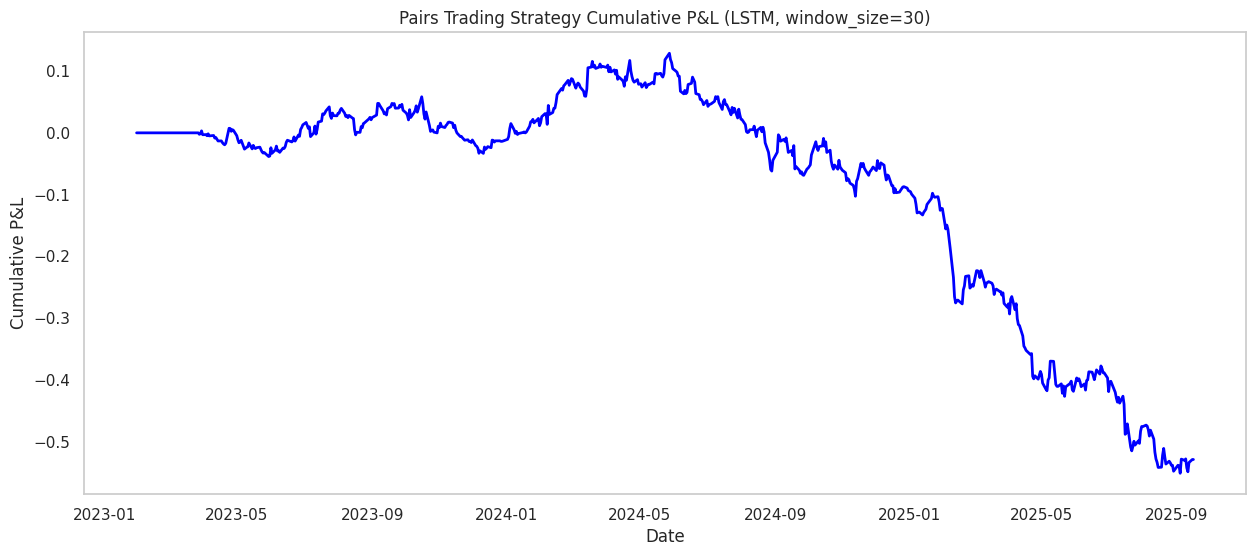

In [41]:
# ---------------------------
# 10. Plot cumulative P&L
# ---------------------------
plt.figure(figsize=(15,6))
plt.plot(Makatjane_test.index, Makatjane_test['cumulative_pnl'], color='blue', linewidth=2)
plt.title('Pairs Trading Strategy Cumulative P&L (LSTM, window_size=30)')
plt.xlabel('Date')
plt.ylabel('Cumulative P&L')
plt.grid(False)
plt.show()


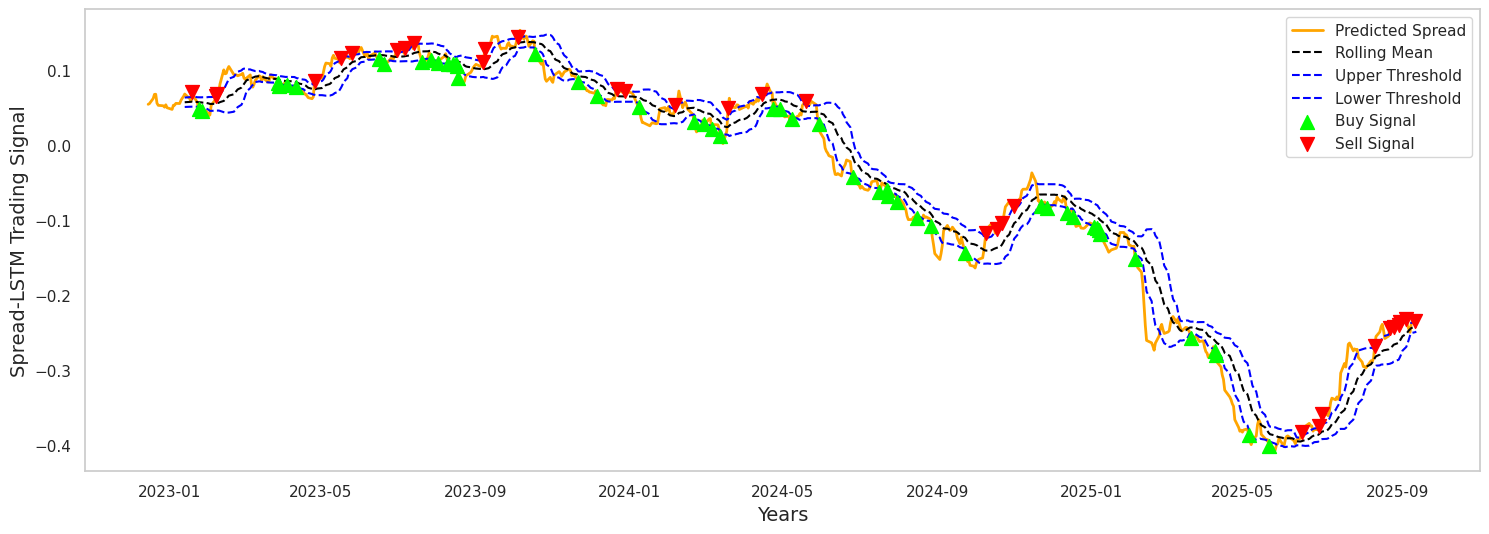

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [42]:
# ---------------------------
# 11. Plot predicted spread with buy/sell signals and save as EPS
# ---------------------------
import matplotlib.pyplot as plt
from google.colab import files

plt.figure(figsize=(18,6))
plt.plot(Makatjane_test.index, Makatjane_test['predicted_spread'], color='orange', label='Predicted Spread', linewidth=2)
plt.plot(Makatjane_test.index, Makatjane_test['rolling_mean'], color='black', linestyle='--', label='Rolling Mean')
plt.plot(Makatjane_test.index, Makatjane_test['upper'], color='blue', linestyle='--', label='Upper Threshold')
plt.plot(Makatjane_test.index, Makatjane_test['lower'], color='blue', linestyle='--', label='Lower Threshold')

plt.scatter(Makatjane_test.index, Makatjane_test['buy_signal'], marker='^', color='lime', s=100, label='Buy Signal', zorder=5)
plt.scatter(Makatjane_test.index, Makatjane_test['sell_signal'], marker='v', color='red', s=100, label='Sell Signal', zorder=5)

plt.title('')
plt.xlabel('Years', fontsize=14)
plt.ylabel('Spread-LSTM Trading Signal', fontsize=14)
plt.legend(loc='best')
plt.grid(False)

# Save the figure as EPS
filename = 'predicted_spread_signals.eps'
plt.savefig(filename, format='eps', dpi=1000, bbox_inches='tight')
plt.show()

# Download the EPS file to your local machine
files.download(filename)


In [35]:
# ---------------------------
# Compute trade outcomes
# ---------------------------
# Filter trades
long_trades = Makatjane_test[Makatjane_test['position'] == 1]['strategy_returns']
short_trades = Makatjane_test[Makatjane_test['position'] == -1]['strategy_returns']

# Probabilities
prob_gain_long  = (long_trades > 0).sum() / len(long_trades) if len(long_trades) > 0 else 0
prob_loss_long  = (long_trades < 0).sum() / len(long_trades) if len(long_trades) > 0 else 0
prob_gain_short = (short_trades > 0).sum() / len(short_trades) if len(short_trades) > 0 else 0
prob_loss_short = (short_trades < 0).sum() / len(short_trades) if len(short_trades) > 0 else 0

# Display results
print(f"Probability of gain when buying:  {prob_gain_long:.2%}")
print(f"Probability of loss when buying: {prob_loss_long:.2%}")
print(f"Probability of gain when selling: {prob_gain_short:.2%}")
print(f"Probability of loss when selling: {prob_loss_short:.2%}")


Probability of gain when buying:  49.66%
Probability of loss when buying: 50.34%
Probability of gain when selling: 51.85%
Probability of loss when selling: 48.15%


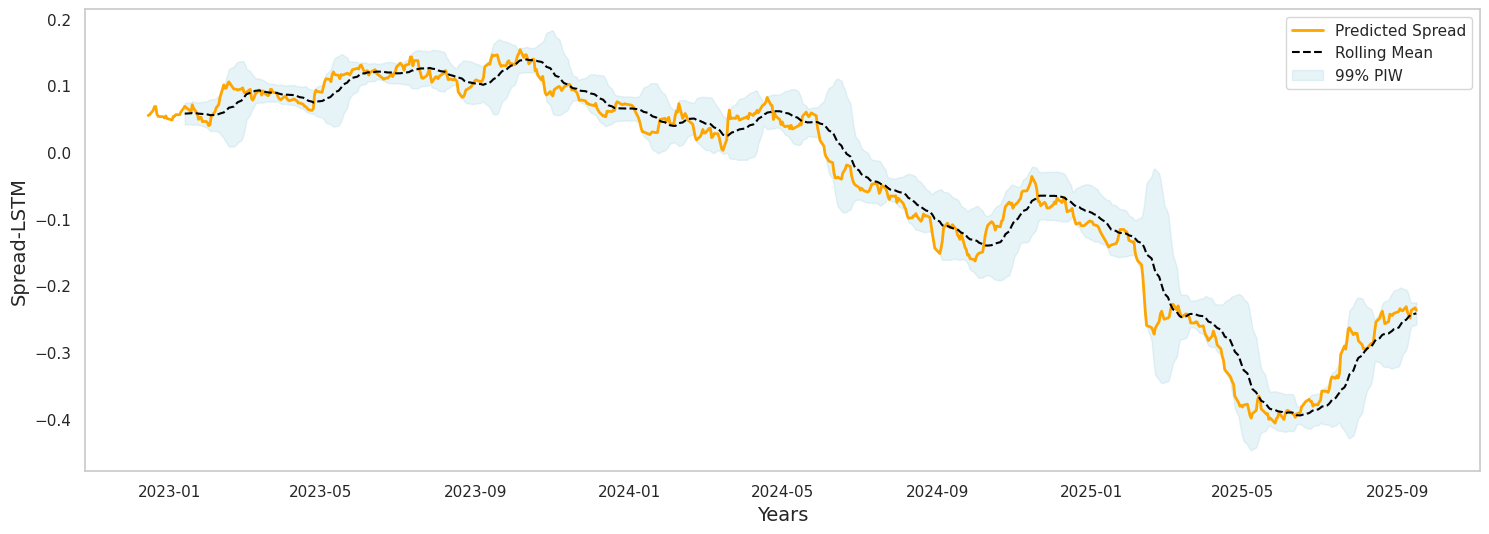

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [48]:
# ---------------------------
# 11. Plot predicted spread with 99% PIW (without trading signals)
# ---------------------------
plt.figure(figsize=(18,6))
plt.plot(Makatjane_test.index, Makatjane_test['predicted_spread'], color='orange', label='Predicted Spread', linewidth=2)
plt.plot(Makatjane_test.index, Makatjane_test['rolling_mean'], color='black', linestyle='--', label='Rolling Mean')

# Plot 99% PIW
plt.fill_between(Makatjane_test.index, Makatjane_test['PIW_lower'], Makatjane_test['PIW_upper'], color='lightblue', alpha=0.3, label='99% PIW')

plt.title('')
plt.xlabel('Years', fontsize=14)
plt.ylabel('Spread-LSTM', fontsize=14)
plt.legend(loc='best')
plt.grid(False)

# Save as high-resolution EPS
plt.savefig('spread_LSTM.eps', format='eps', dpi=1000)

plt.show()
from google.colab import files
files.download('spread_LSTM.eps')


In [50]:
# Compute the 99% PIW as the difference between upper and lower bounds
Makatjane_test['PIW_99'] = Makatjane_test['PIW_upper'] - Makatjane_test['PIW_lower']

# Print summary statistics
mean_piw = Makatjane_test['PIW_99'].mean()
min_piw = Makatjane_test['PIW_99'].min()
max_piw = Makatjane_test['PIW_99'].max()
final_piw = Makatjane_test['PIW_99'].iloc[-1]

print(f"99% PIW Summary:")
print(f"Mean PIW: {mean_piw:.6f}")
print(f"Min PIW: {min_piw:.6f}")
print(f"Max PIW: {max_piw:.6f}")
print(f"Final PIW value: {final_piw:.6f}")


99% PIW Summary:
Mean PIW: 0.077197
Min PIW: 0.023248
Max PIW: 0.309414
Final PIW value: 0.033650


In [45]:
# ---------------------------
# Performance metrics
# ---------------------------

# Sharpe ratio (assuming daily returns, risk-free rate = 0)
sharpe_ratio = (
    Makatjane_test['strategy_returns'].mean() /
    Makatjane_test['strategy_returns'].std()
) * np.sqrt(252) if Makatjane_test['strategy_returns'].std() != 0 else 0

# Max Drawdown
rolling_max = Makatjane_test['cumulative_pnl'].cummax()
drawdown = rolling_max - Makatjane_test['cumulative_pnl']
max_drawdown = drawdown.max()

# Hit ratio = percentage of positive trades
hit_ratio = (Makatjane_test['strategy_returns'] > 0).sum() / len(Makatjane_test['strategy_returns']) * 100

# Print results
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Max Drawdown: {max_drawdown:.2f}")
print(f"Hit Ratio: {hit_ratio:.2f}%")


Sharpe Ratio: -1.34
Max Drawdown: 0.68
Hit Ratio: 44.70%


In [38]:
# ---------------------------
# 10. Compute trading probabilities
# ---------------------------
# Buy trades
buy_trades = Makatjane_test[Makatjane_test['position'].shift(1) == 1]['strategy_returns']
buy_gain_prob = (buy_trades > 0).sum() / len(buy_trades) * 100
buy_loss_prob = (buy_trades <= 0).sum() / len(buy_trades) * 100

# Sell trades
sell_trades = Makatjane_test[Makatjane_test['position'].shift(1) == -1]['strategy_returns']
sell_gain_prob = (sell_trades > 0).sum() / len(sell_trades) * 100
sell_loss_prob = (sell_trades <= 0).sum() / len(sell_trades) * 100

print("\n--- LSTM Trading Probabilities ---")
print(f"Probability of gain when buying:  {buy_gain_prob:.2f}%")
print(f"Probability of loss when buying: {buy_loss_prob:.2f}%")
print(f"Probability of gain when selling: {sell_gain_prob:.2f}%")
print(f"Probability of loss when selling: {sell_loss_prob:.2f}%")



--- LSTM Trading Probabilities ---
Probability of gain when buying:  53.02%
Probability of loss when buying: 46.98%
Probability of gain when selling: 51.85%
Probability of loss when selling: 48.15%


In [39]:
# ---------------------------
# 9. Trading summary
# ---------------------------
total_trades = ((Makatjane_test['buy_signal'].notna()) |
                (Makatjane_test['sell_signal'].notna())).sum()
total_pnl = Makatjane_test['strategy_returns'].sum()
max_drawdown = (Makatjane_test['cumulative_pnl'].cummax() - Makatjane_test['cumulative_pnl']).max()
avg_daily_pnl = Makatjane_test['strategy_returns'].mean()
std_daily_pnl = Makatjane_test['strategy_returns'].std()

print("\n--- Trading Summary ---")
print(f"Total trades executed: {total_trades}")
print(f"Total strategy P&L: {total_pnl:.4f}")
print(f"Maximum drawdown: {max_drawdown:.4f}")
print(f"Average daily P&L: {avg_daily_pnl:.4f}")
print(f"Std dev of daily P&L: {std_daily_pnl:.4f}")



--- Trading Summary ---
Total trades executed: 82
Total strategy P&L: 0.2395
Maximum drawdown: 0.1464
Average daily P&L: 0.0003
Std dev of daily P&L: 0.0082


# Training and Testing of the Deep Neural Networks


In [20]:
import numpy as np
import tensorflow as tf
import random
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import os

# ---------------------------
# 0. Set seeds for reproducibility
# ---------------------------
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

# Optional: make TensorFlow operations deterministic (may slow down training)
# For TensorFlow 2.x
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# ---------------------------
# 1. Prepare lagged features
# ---------------------------
def create_lags(series, n_lags=5):
    X, y = [], []
    for i in range(n_lags, len(series)):
        X.append(series.iloc[i-n_lags:i].values) # Use iloc for index-based access
        y.append(series.iloc[i]) # Use iloc for index-based access
    return np.array(X), np.array(y)

n_lags = 5
spread_series = Makatjane['spread']  # Use Makatjane['spread'] instead of undefined spread
X, y = create_lags(spread_series, n_lags)

# Split into train/test
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Scale features
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1))

# ---------------------------
# 2. Build and train DNN
# ---------------------------

model = Sequential()
model.add(Dense(64, input_dim=n_lags, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = model.fit(
    X_train_scaled, y_train_scaled,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/200


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.3304 - val_loss: 0.0243
Epoch 2/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0463 - val_loss: 0.0207
Epoch 3/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0384 - val_loss: 0.0160
Epoch 4/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0321 - val_loss: 0.0169
Epoch 5/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0299 - val_loss: 0.0158
Epoch 6/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0271 - val_loss: 0.0139
Epoch 7/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0240 - val_loss: 0.0151
Epoch 8/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0250 - val_loss: 0.0165
Epoch 9/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0218 - val_loss: 0.0131
Epoch 10/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0238 - val_loss: 0.0178
Epoch 11/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0216 - val_loss: 0.0144
Epoch 12/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0218 - val_lo

In [23]:
# ---------------------------
# 3. Predict spread
# ---------------------------
predicted_scaled_test = model.predict(X_test_scaled)
predicted_test_spread = scaler_y.inverse_transform(predicted_scaled_test)

Makatjane_test = pd.DataFrame(index=spread_series.index[-len(predicted_test_spread):])
Makatjane_test['predicted_spread'] = predicted_test_spread.flatten()

# ---------------------------
# 4. Compute dynamic thresholds
# ---------------------------
window = 20
Makatjane_test['rolling_mean'] = Makatjane_test['predicted_spread'].rolling(window).mean()
Makatjane_test['rolling_std'] = Makatjane_test['predicted_spread'].rolling(window).std()
Makatjane_test['upper'] = Makatjane_test['rolling_mean'] + Makatjane_test['rolling_std']
Makatjane_test['lower'] = Makatjane_test['rolling_mean'] - Makatjane_test['rolling_std']

# ---------------------------
# 5. Generate buy/sell signals
# ---------------------------
Makatjane_test['buy_signal'] = np.where(
    (Makatjane_test['predicted_spread'] < Makatjane_test['lower']) &
    (Makatjane_test['predicted_spread'].shift(1) > Makatjane_test['lower']),
    Makatjane_test['predicted_spread'], np.nan
)

Makatjane_test['sell_signal'] = np.where(
    (Makatjane_test['predicted_spread'] > Makatjane_test['upper']) &
    (Makatjane_test['predicted_spread'].shift(1) < Makatjane_test['upper']),
    Makatjane_test['predicted_spread'], np.nan
)

# ---------------------------
# 6. Compute positions
# ---------------------------
Makatjane_test['position'] = 0
Makatjane_test.loc[Makatjane_test['buy_signal'].notna(), 'position'] = 1
Makatjane_test.loc[Makatjane_test['sell_signal'].notna(), 'position'] = -1
Makatjane_test['position'] = Makatjane_test['position'].replace(to_replace=0, method='ffill').fillna(0)

# ---------------------------
# 7. Strategy returns & cumulative P&L
# ---------------------------
test_spread = spread_series[-len(Makatjane_test):].ffill().fillna(0)
spread_returns_test = test_spread.diff().shift(-1).fillna(0)

transaction_cost = 0.0005
Makatjane_test['strategy_returns'] = Makatjane_test['position'] * spread_returns_test
Makatjane_test['strategy_returns'] -= transaction_cost * Makatjane_test['position'].diff().abs().fillna(0)
Makatjane_test['cumulative_pnl'] = Makatjane_test['strategy_returns'].cumsum()

# ---------------------------
# 8. Trading summary
# ---------------------------
total_trades = ((Makatjane_test['buy_signal'].notna()) | (Makatjane_test['sell_signal'].notna())).sum()
total_profit = Makatjane_test['strategy_returns'].sum()
max_drawdown = (Makatjane_test['cumulative_pnl'].cummax() - Makatjane_test['cumulative_pnl']).max()

print("\n--- Trading Summary ---")
print(f"Total trades executed: {total_trades}")
print(f"Total strategy P&L: {total_profit:.4f}")
print(f"Maximum drawdown: {max_drawdown:.4f}")
print(f"Average daily P&L: {Makatjane_test['strategy_returns'].mean():.4f}")
print(f"Std dev of daily P&L: {Makatjane_test['strategy_returns'].std():.4f}")

# ---------------------------
# 9. Error Metrics
# ---------------------------
from sklearn.metrics import mean_squared_error, mean_absolute_error

y_true = y_test.flatten()
y_pred = predicted_test_spread.flatten()

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mse)
mfe = np.mean(y_pred - y_true)

print("\n--- Error Metrics ---")
print(f"MSE : {mse:.6f}")
print(f"MAE : {mae:.6f}")
print(f"MFE : {mfe:.6f}")
print(f"RMSE: {rmse:.6f}")

# ---------------------------
# 10. Risk/Performance Metrics
# ---------------------------
sharpe_ratio = Makatjane_test['strategy_returns'].mean() / Makatjane_test['strategy_returns'].std()
hit_ratio = (Makatjane_test['strategy_returns'] > 0).sum() / len(Makatjane_test['strategy_returns']) * 100

print("\n--- Performance Metrics ---")
print(f"Sharpe Ratio : {sharpe_ratio:.2f}")
print(f"Max Drawdown : {max_drawdown:.2f}")
print(f"Hit Ratio    : {hit_ratio:.2f}%")




22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

--- Trading Summary ---
Total trades executed: 82
Total strategy P&L: -0.4889
Maximum drawdown: 0.6550
Average daily P&L: -0.0007
Std dev of daily P&L: 0.0095

--- Error Metrics ---
MSE : 0.000304
MAE : 0.011948
MFE : 0.007341
RMSE: 0.017436

--- Performance Metrics ---
Sharpe Ratio : -0.08
Max Drawdown : 0.66
Hit Ratio    : 46.30%


/tmp/ipython-input-2202114771.py:40: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  Makatjane_test['position'] = Makatjane_test['position'].replace(to_replace=0, method='ffill').fillna(0)


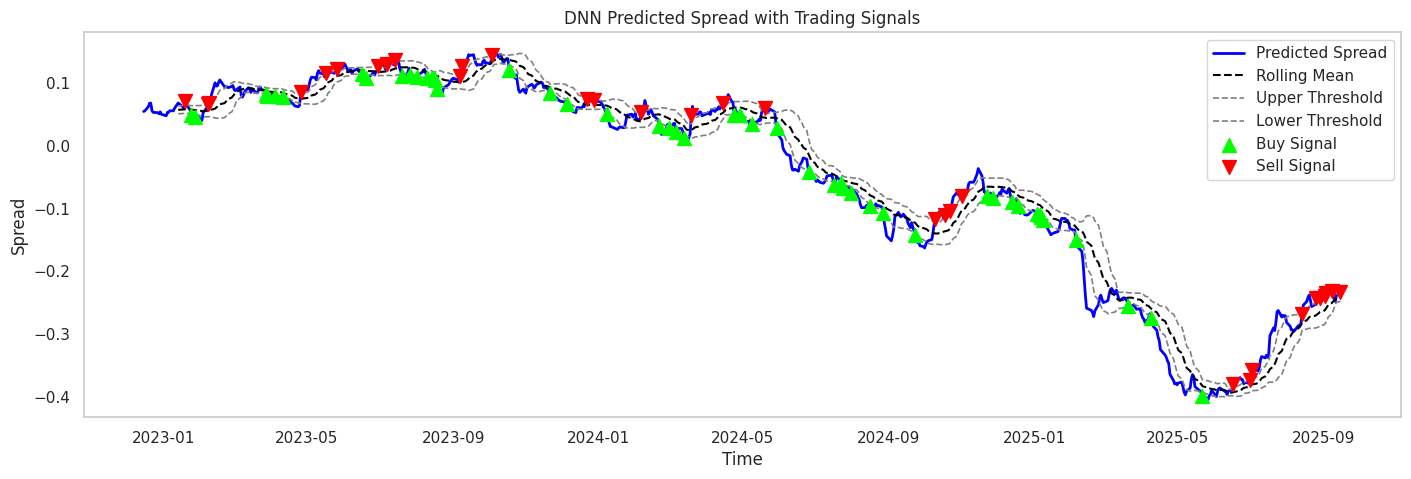

In [56]:
# ---------------------------
# 9. Plot predicted spread with signals
# ---------------------------
plt.figure(figsize=(17,5))
plt.plot(Makatjane_test['predicted_spread'], color='blue', linewidth=2, label='Predicted Spread')
plt.plot(Makatjane_test['rolling_mean'], color='black', linestyle='--', linewidth=1.5, label='Rolling Mean')
plt.plot(Makatjane_test['upper'], color='grey', linestyle='--', linewidth=1.2, label='Upper Threshold')
plt.plot(Makatjane_test['lower'], color='grey', linestyle='--', linewidth=1.2, label='Lower Threshold')

plt.scatter(Makatjane_test.index, Makatjane_test['buy_signal'], marker='^', color='lime', s=100, label='Buy Signal', zorder=5)
plt.scatter(Makatjane_test.index, Makatjane_test['sell_signal'], marker='v', color='red', s=100, label='Sell Signal', zorder=5)
plt.title('DNN Predicted Spread with Trading Signals')
plt.ylabel('Spread')
plt.xlabel('Time')
plt.legend(loc='best')
plt.grid(False)
plt.show()




In [40]:
# ---------------------------
# 0. Imports and seed
# ---------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# Set seeds for reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# ---------------------------
# 1. Lagged features
# ---------------------------
def create_lags(series, n_lags=5):
    X, y = [], []
    for i in range(n_lags, len(series)):
        X.append(series[i-n_lags:i].values)
        y.append(series[i])
    return np.array(X), np.array(y)

n_lags = 5
spread_series = Makatjane['spread']  # your spread series
X, y = create_lags(spread_series, n_lags)

# Train-test split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Scale features
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1))

# ---------------------------
# 2. Build and train DNN
# ---------------------------
model = Sequential([
    Dense(64, input_dim=n_lags, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = model.fit(
    X_train_scaled, y_train_scaled,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# ---------------------------
# 3. Predict spread
# ---------------------------
predicted_scaled_test = model.predict(X_test_scaled)
predicted_test_spread = scaler_y.inverse_transform(predicted_scaled_test)

Makatjane_test = pd.DataFrame(index=spread_series.index[-len(predicted_test_spread):])
Makatjane_test['predicted_spread'] = predicted_test_spread.flatten()

# ---------------------------
# 4. Dynamic thresholds
# ---------------------------
window = 20
Makatjane_test['rolling_mean'] = Makatjane_test['predicted_spread'].rolling(window).mean()
Makatjane_test['rolling_std'] = Makatjane_test['predicted_spread'].rolling(window).std()
Makatjane_test['upper'] = Makatjane_test['rolling_mean'] + Makatjane_test['rolling_std']
Makatjane_test['lower'] = Makatjane_test['rolling_mean'] - Makatjane_test['rolling_std']

# ---------------------------
# 5. Generate buy/sell signals
# ---------------------------
Makatjane_test['buy_signal'] = np.where(
    (Makatjane_test['predicted_spread'] < Makatjane_test['lower']) &
    (Makatjane_test['predicted_spread'].shift(1) > Makatjane_test['lower']),
    Makatjane_test['predicted_spread'], np.nan
)

Makatjane_test['sell_signal'] = np.where(
    (Makatjane_test['predicted_spread'] > Makatjane_test['upper']) &
    (Makatjane_test['predicted_spread'].shift(1) < Makatjane_test['upper']),
    Makatjane_test['predicted_spread'], np.nan
)

# ---------------------------
# 6. Compute positions
# ---------------------------
Makatjane_test['position'] = 0
Makatjane_test.loc[Makatjane_test['buy_signal'].notna(), 'position'] = 1
Makatjane_test.loc[Makatjane_test['sell_signal'].notna(), 'position'] = -1

# Forward-fill positions for minimum holding period
holding_period = 3
positions = Makatjane_test['position'].copy()
for i in range(len(positions)):
    if positions[i] != 0:
        for j in range(1, holding_period):
            if i+j < len(positions):
                positions[i+j] = positions[i]
Makatjane_test['position'] = positions.fillna(0)

# Optional: risk-adjusted position sizing
Makatjane_test['position'] = (Makatjane_test['predicted_spread'] - Makatjane_test['rolling_mean']) / Makatjane_test['rolling_std']
Makatjane_test['position'] = Makatjane_test['position'].clip(-1,1).fillna(0)

# ---------------------------
# 7. Strategy returns & cumulative P&L
# ---------------------------
test_spread = spread_series[-len(Makatjane_test):].ffill().fillna(0)
spread_returns_test = test_spread.diff().fillna(0)

transaction_cost = 0.0005
Makatjane_test['strategy_returns'] = Makatjane_test['position'] * spread_returns_test
Makatjane_test['strategy_returns'] -= transaction_cost * Makatjane_test['position'].diff().abs().fillna(0)
Makatjane_test['cumulative_pnl'] = Makatjane_test['strategy_returns'].cumsum()

# ---------------------------
# 8. Trading summary
# ---------------------------
print(Makatjane_test[['position','strategy_returns','cumulative_pnl']].head(10))

total_trades = ((Makatjane_test['buy_signal'].notna()) | (Makatjane_test['sell_signal'].notna())).sum()
total_profit = Makatjane_test['strategy_returns'].sum()
max_drawdown = (Makatjane_test['cumulative_pnl'].cummax() - Makatjane_test['cumulative_pnl']).max()

print("\n--- Trading Summary ---")
print(f"Total trades executed: {total_trades}")
print(f"Total strategy P&L: {total_profit:.4f}")
print(f"Maximum drawdown: {max_drawdown:.4f}")
print(f"Average daily P&L: {Makatjane_test['strategy_returns'].mean():.4f}")
print(f"Std dev of daily P&L: {Makatjane_test['strategy_returns'].std():.4f}")






/tmp/ipython-input-29448603.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(series[i])
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3304 - val_loss: 0.0243
Epoch 2/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0463 - val_loss: 0.0207
Epoch 3/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0384 - val_loss: 0.0160
Epoch 4/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0321 - val_loss: 0.0169
Epoch 5/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0299 - val_loss: 0.0158
Epoch 6/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0271 - val_loss: 0.0139
Epoch 7/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0240 - val_loss: 0.0151
Epoch 8/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0250 - val_loss: 0.0165
Epoch 9/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0218 - val_loss: 0.0131
Epoch 10/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0238 - val_loss: 0.0178
Epoch 11/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0216 - val_loss: 0.0144
Epoch 12/200
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0

/tmp/ipython-input-29448603.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if positions[i] != 0:
/tmp/ipython-input-29448603.py:117: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  positions[i+j] = positions[i]
/tmp/ipython-input-29448603.py:117: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  positions[i+j] = positions[i]


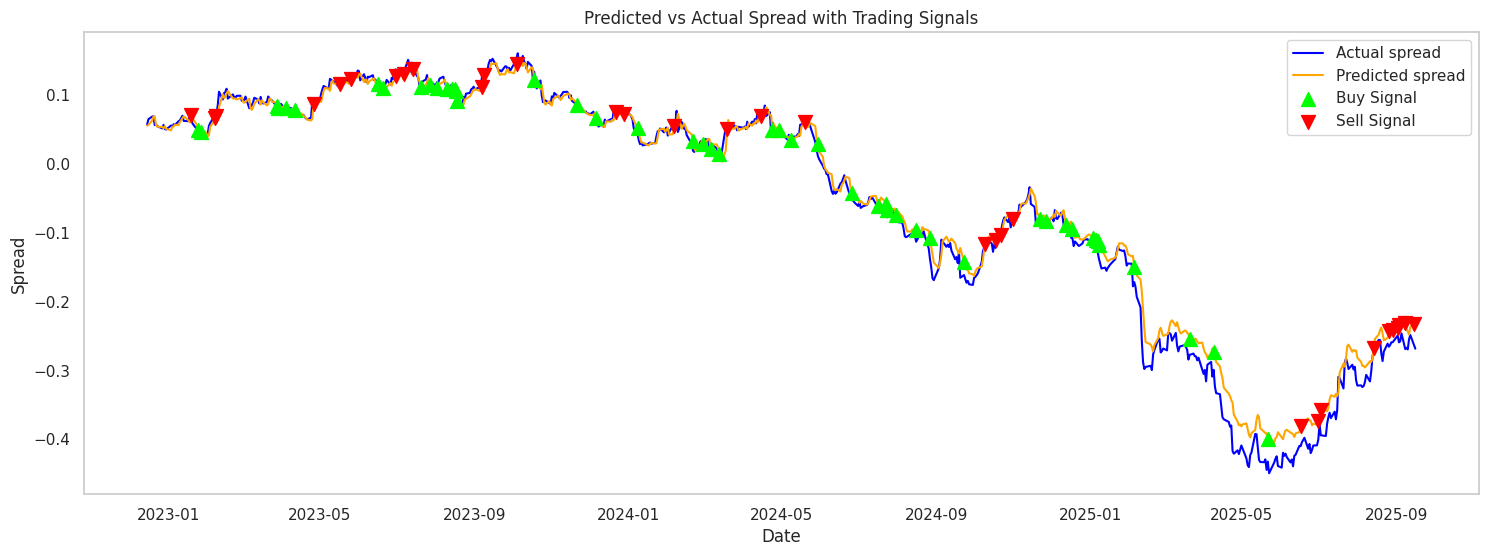

In [53]:
# ---------------------------
# 10. Plot predicted vs actual spread
# ---------------------------
plt.figure(figsize=(18,6))
plt.plot(Makatjane_test.index, y_test, label='Actual spread', color='blue')
plt.plot(Makatjane_test.index, predicted_test_spread, label='Predicted spread', color='orange')
plt.scatter(Makatjane_test.index, Makatjane_test['buy_signal'], marker='^', color='lime', s=100, label='Buy Signal', zorder=5)
plt.scatter(Makatjane_test.index, Makatjane_test['sell_signal'], marker='v', color='red', s=100, label='Sell Signal', zorder=5)
plt.title('Predicted vs Actual Spread with Trading Signals')
plt.xlabel('Date')
plt.ylabel('Spread')
plt.legend()
plt.grid(False)
plt.show()

In [31]:
# ---------------------------
# Trading summary
# ---------------------------
total_trades = ((Makatjane_test['buy_signal'].notna()) |
                (Makatjane_test['sell_signal'].notna())).sum()

total_pnl = Makatjane_test['strategy_returns'].sum()

cumulative_max = Makatjane_test['cumulative_pnl'].cummax()
max_drawdown = (cumulative_max - Makatjane_test['cumulative_pnl']).max()

avg_daily_pnl = Makatjane_test['strategy_returns'].mean()
std_daily_pnl = Makatjane_test['strategy_returns'].std()

print("\n--- Trading Summary ---")
print(f"Total trades executed: {total_trades}")
print(f"Total strategy P&L: {total_pnl:.4f}")
print(f"Maximum drawdown: {max_drawdown:.4f}")
print(f"Average daily P&L: {avg_daily_pnl:.4f}")
print(f"Std dev of daily P&L: {std_daily_pnl:.4f}")



--- Trading Summary ---
Total trades executed: 82
Total strategy P&L: 0.2395
Maximum drawdown: 0.1464
Average daily P&L: 0.0003
Std dev of daily P&L: 0.0082


In [32]:
# ---------------------------
# 3. Predict on test set
# ---------------------------
y_pred_scaled = model.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Align predictions with test set index
Makatjane_dnn = pd.DataFrame(index=spread_series.index[n_lags+split:])
Makatjane_dnn["actual_spread"] = y_test
Makatjane_dnn["predicted_spread"] = y_pred.flatten()

# ---------------------------
# 4. Generate signals
# ---------------------------
Makatjane_dnn["position"] = 0
Makatjane_dnn.loc[Makatjane_dnn["predicted_spread"] > Makatjane_dnn["actual_spread"].shift(1), "position"] = 1   # long
Makatjane_dnn.loc[Makatjane_dnn["predicted_spread"] < Makatjane_dnn["actual_spread"].shift(1), "position"] = -1  # short

# Compute spread returns
spread_returns = Makatjane_dnn["actual_spread"].diff().fillna(0)
Makatjane_dnn["strategy_returns"] = Makatjane_dnn["position"].shift(1) * spread_returns

# ---------------------------
# 5. Probability of gain/loss
# ---------------------------
long_trades = Makatjane_dnn[Makatjane_dnn["position"] == 1]["strategy_returns"]
short_trades = Makatjane_dnn[Makatjane_dnn["position"] == -1]["strategy_returns"]

# Probabilities
prob_gain_long = (long_trades > 0).mean()
prob_loss_long = (long_trades <= 0).mean()
prob_gain_short = (short_trades > 0).mean()
prob_loss_short = (short_trades <= 0).mean()

# ---------------------------
# 6. Display results
# ---------------------------
print("\n--- DNN Trading Probabilities ---")
print(f"Probability of gain when buying:  {prob_gain_long:.2%}")
print(f"Probability of loss when buying: {prob_loss_long:.2%}")
print(f"Probability of gain when selling: {prob_gain_short:.2%}")
print(f"Probability of loss when selling: {prob_loss_short:.2%}")


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

--- DNN Trading Probabilities ---
Probability of gain when buying:  47.15%
Probability of loss when buying: 52.85%
Probability of gain when selling: 53.31%
Probability of loss when selling: 46.69%
